## `Sales Data Analysis`

### `import libraries`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msg
from datasist.structdata import detect_outliers
import os 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn_features.transformers import DataFrameSelector

### `Load Data`

In [2]:
file_path=os.path.join(os.getcwd(),"sales_data.csv")

In [3]:
df=pd.read_csv(file_path)

In [4]:
df.head()

,date,product,category,price,quantity,revenue
0,2022-01-01,Smartphone,Electronics,600.0,10.0,6000.0
1,2022-01-01,Laptop,Electronics,1200.0,5.0,6000.0
2,2022-01-02,T-Shirt,Clothing,20.0,50.0,1000.0
3,2022-01-03,Headphones,Electronics,100.0,20.0,2000.0
4,2022-01-04,T-Shirt,Clothing,20.0,25.0,500.0


## Dataset

The dataset you will be using is a CSV file called sales_data.csv. It contains information about sales made by a fictional company over the course of a year. The columns in the dataset are as follows:

- date: The date of the sale (in YYYY-MM-DD format)
- product: The name of the product sold
- category: The category of the product (e.g. "electronics", "clothing", etc.)
- price: The price of the product (in USD)
- quantity: The quantity of the product sold
- revenue: The total revenue generated by the sale (i.e. price * quantity)

Don't forget to clean the data provided in the CSV file.

### `Distinguishing Attribute`

In [5]:
df.sample()

,date,product,category,price,quantity,revenue
46,2022-02-14,Wallet,Accessories,30.0,30.0,900.0


In [6]:
# check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      369 non-null    object 
 1   product   369 non-null    object 
 2   category  369 non-null    object 
 3   price     367 non-null    float64
 4   quantity  368 non-null    float64
 5   revenue   368 non-null    float64
dtypes: float64(3), object(3)
memory usage: 17.4+ KB


In [7]:
df.describe()

,price,quantity,revenue
count,367.000000,368.000000,368.000000
mean,211.226158,14.565217,2060.679348
std,227.335170,8.595740,1910.930790
min,20.000000,3.000000,300.000000
25%,50.000000,8.000000,800.000000
50%,100.000000,12.000000,1200.000000
75%,300.000000,20.000000,2400.000000
max,1200.000000,50.000000,7200.000000


In [8]:
df.describe(include="object")

,date,product,category
count,369,369,369
unique,365,14,8
top,2022-01-01,Smartphone,Electronics
freq,2,82,130


### `Data Cleaning`

In [9]:
# date should be hanlded to date time 
df["date"]=pd.to_datetime(df["date"],errors="coerce",format="%Y-%m-%d")

In [10]:
#date changed --> done
df.dtypes

date        datetime64[ns]
product             object
category            object
price              float64
quantity           float64
revenue            float64
dtype: object

In [11]:
df.isna().sum().sort_values(ascending=False)

price       2
quantity    1
revenue     1
date        0
product     0
category    0
dtype: int64

In [12]:
df.isna().sum().sort_values(ascending=False)/df.shape[0]

price       0.00542
quantity    0.00271
revenue     0.00271
date        0.00000
product     0.00000
category    0.00000
dtype: float64

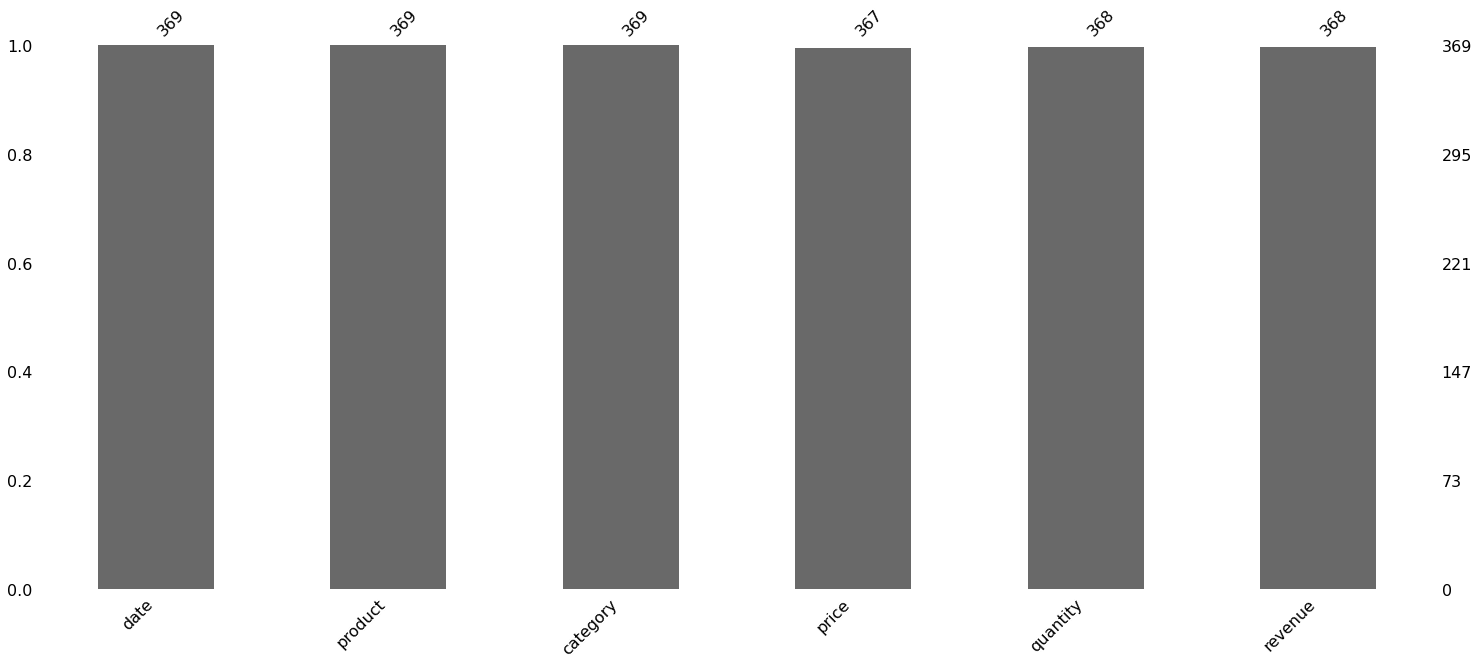

In [13]:
# missing_values
msg.bar(df);

In [14]:
num_cols=df.select_dtypes(include="number").columns.to_list()
cat_cols=df.select_dtypes(exclude="number").columns.to_list()

In [15]:
# impute numerical with mean ,caterogical with mode
num_pipe=Pipeline(steps=[
    ("selector",DataFrameSelector(num_cols)),
    ("num_impuer",SimpleImputer(strategy="mean"))
])
cat_pipe=Pipeline(steps=[
     ("selector",DataFrameSelector(cat_cols)),
    ("cat_impuer",SimpleImputer(strategy="most_frequent"))
 
])
all_pipe=FeatureUnion(transformer_list=[
    ("num_pipe",num_pipe),
    ("cat_impuer",cat_pipe)
])
df=pd.DataFrame(all_pipe.fit_transform(df),columns=num_cols+cat_cols)

In [16]:
df.isna().sum()

price       0
quantity    0
revenue     0
date        0
product     0
category    0
dtype: int64

In [17]:
# check duplicated
df.duplicated().sum()

1

In [18]:
df.drop_duplicates(inplace=True)

In [19]:
df.duplicated().sum()

0

In [37]:
# check_oultiers --> impute with medain
for col in num_cols:
    idx_outliers=detect_outliers(data=df,n=1,features=[col])
    #impute
    df.loc[idx_outliers,col]=df[col].median()

### `EDA`

1. What was the total revenue generated by the company over the course of the year?

In [39]:
df.head()

,price,quantity,revenue,date,product,category
0,600.0,10.0,6000.0,2022-01-01,Smartphone,Electronics
1,1200.0,5.0,6000.0,2022-01-01,Laptop,Electronics
2,20.0,50.0,1000.0,2022-01-02,T-Shirt,Clothing
3,100.0,20.0,2000.0,2022-01-03,Headphones,Electronics
4,20.0,25.0,500.0,2022-01-04,T-Shirt,Clothing


In [41]:
# feature engineering
df["year"]=df["date"].dt.year

In [43]:
df["year"].unique()

array([2022], dtype=int64)

In [42]:
df.groupby(by="year")[["revenue"]].agg("sum").sort_values(by="revenue",ascending=False)

,revenue
year,
2022,759190.679348


2. Which product had the highest revenue? How much revenue did it generate?

In [45]:
df.groupby(by="product")[["revenue"]].agg("sum").sort_values(by="revenue",ascending=False).head(1)

,revenue
product,
Smartphone,434400.0


In [47]:
df[df["product"]=="Smartphone"]

,price,quantity,revenue,date,product,category,year
0,600.0,10.0,6000.0,2022-01-01,Smartphone,Electronics,2022
6,600.0,8.0,4800.0,2022-01-06,Smartphone,Electronics,2022
13,600.0,12.0,7200.0,2022-01-12,Smartphone,Electronics,2022
18,600.0,6.0,3600.0,2022-01-17,Smartphone,Electronics,2022
23,600.0,7.0,4200.0,2022-01-22,Smartphone,Electronics,2022
...,...,...,...,...,...,...,...
348,600.0,12.0,7200.0,2022-12-11,Smartphone,Electronics,2022
352,600.0,6.0,3600.0,2022-12-15,Smartphone,Electronics,2022
358,600.0,7.0,4200.0,2022-12-21,Smartphone,Electronics,2022
363,600.0,9.0,5400.0,2022-12-26,Smartphone,Electronics,2022


3. What was the average price of a product sold by the company?

In [49]:
df.groupby(by="product")[["price"]].agg("mean").sort_values(by="price",ascending=False)

,price
product,
Laptop,1200.000000
Smartphone,600.000000
Tablet,400.000000
Smartwatch,200.000000
Watch,152.783007
Coat,100.000000
Headphones,100.000000
Sneakers,80.000000
Speaker,80.000000


4. What was the total quantity of products sold by the company?

In [54]:
df.groupby(by="product")["product"].agg(len).sort_values(ascending=False).to_frame()

,product
product,
Smartphone,82
T-Shirt,38
Smartwatch,36
Coat,35
Speaker,25
Backpack,24
Jeans,24
Sneakers,24
Hoodie,23


5. Which category had the highest revenue? How much revenue did it generate?

In [55]:
df.groupby(by="category")[["revenue"]].agg("sum").sort_values(by="revenue",ascending=False).head(1)

,revenue
category,
Electronics,516080.0


In [56]:
df[df["category"]=="Electronics"]

,price,quantity,revenue,date,product,category,year
0,600.0,10.0,6000.0,2022-01-01,Smartphone,Electronics,2022
1,1200.0,5.0,6000.0,2022-01-01,Laptop,Electronics,2022
3,100.0,20.0,2000.0,2022-01-03,Headphones,Electronics,2022
6,600.0,8.0,4800.0,2022-01-06,Smartphone,Electronics,2022
7,400.0,5.0,2000.0,2022-01-06,Tablet,Electronics,2022
...,...,...,...,...,...,...,...
357,400.0,6.0,2400.0,2022-12-20,Tablet,Electronics,2022
358,600.0,7.0,4200.0,2022-12-21,Smartphone,Electronics,2022
363,600.0,9.0,5400.0,2022-12-26,Smartphone,Electronics,2022
366,100.0,10.0,1000.0,2022-12-29,Headphones,Electronics,2022


6. What was the average revenue per sale?

In [57]:
df.groupby(by="date")[["revenue"]].agg("mean").sort_values(by="revenue",ascending=False)

,revenue
date,
2022-11-11,7200.0
2022-08-12,7200.0
2022-04-12,7200.0
2022-09-12,7200.0
2022-12-11,7200.0
...,...
2022-11-22,300.0
2022-05-24,300.0
2022-09-23,300.0


7. What was the total revenue generated in each quarter of the year? (i.e. Q1, Q2, Q3, Q4)

First quarter, Q1: 1 January – 31 March (90 days or 91 days in leap years) 
Second quarter, Q2: 1 April – 30 June (91 days) 
Third quarter, Q3: 1 July – 30 September (92 days)
 Fourth quarter, Q4: 1 October – 31 December (92 days)

In [59]:
# feature engineering
df["month"]=df["date"].dt.month

In [61]:
cut_quarters = ['Q1', "Q2", 'Q3', 'Q4']
cut_bins =[1, 3, 6, 9, 12]
df['quarters'] = pd.cut(df['month'], bins=cut_bins, labels =cut_quarters)

In [62]:
df.groupby(by="quarters")[["revenue"]].agg("sum").sort_values(by="revenue",ascending=False)

,revenue
quarters,
Q3,197680.000000
Q4,193380.000000
Q2,186030.679348
Q1,116300.000000
